In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print(" All libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


 All libraries imported successfully
PyTorch version: 2.9.1+cpu
CUDA available: False


In [11]:
# ==================== CONFIGURATION ====================

# Dataset
DATASET = 'CIFAR10'
DATA_DIR = './data'
NUM_CLASSES = 10

# Model
MODEL_NAME = 'ResNet18'
BATCH_SIZE = 128
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# Paths
MODEL_DIR = './models'
RESULT_DIR = './results'

# Create directories
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULT_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

# Seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

print(" Configuration set")


Using device: cpu
 Configuration set


 Training samples: 50000
 Testing samples: 10000


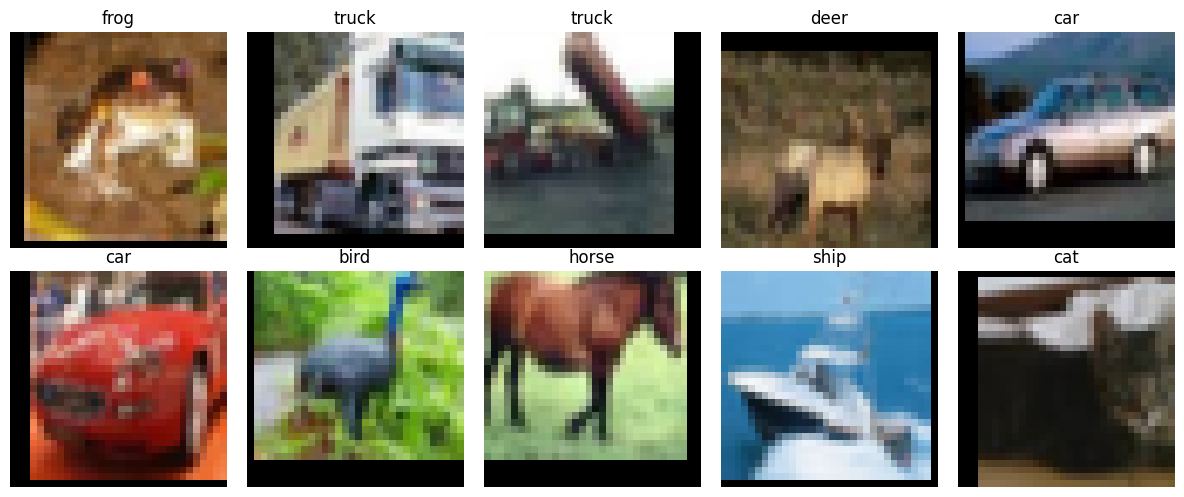

 Data loaded!


In [15]:
# ==================== LOAD DATASET ====================

print("Downloading CIFAR-10 dataset...")

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                       (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                       (0.2023, 0.1994, 0.2010))
])

train_dataset = datasets.CIFAR10(
    root=DATA_DIR, 
    train=True, 
    download=True,
    transform=transform_train
)

test_dataset = datasets.CIFAR10(
    root=DATA_DIR, 
    train=False, 
    download=True, 
    transform=transform_test
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f" Training samples: {len(train_dataset)}")
print(f" Testing samples: {len(test_dataset)}")

# Show sample images
CIFAR10_CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    ax = axes[i // 5, i % 5]
    img, label = train_dataset[i]
    img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + \
          torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    img = img.clamp(0, 1)
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f'{CIFAR10_CLASSES[label]}')
    ax.axis('off')

plt.tight_layout()
plt.savefig('./results/sample_images.png', dpi=100)
plt.show()
print(" Data loaded!")


In [16]:
# ==================== MODEL ====================

model = models.resnet18(pretrained=False, num_classes=NUM_CLASSES)
model = model.to(DEVICE)

print(" ResNet-18 model created")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(" Ready to train")


 ResNet-18 model created
Total parameters: 11,181,642
 Ready to train


In [17]:
# ==================== TRAINING FUNCTIONS ====================

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc='Training')
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        progress_bar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{100*correct/total:.2f}%'})
    
    return total_loss / len(train_loader), 100 * correct / total

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(test_loader), 100 * correct / total

print("Functions defined")


Functions defined


In [7]:
# ==================== TRAIN ====================

print("\n" + "="*60)
print("TRAINING BASELINE MODEL")
print("="*60 + "\n")

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

best_accuracy = 0

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Test Loss:  {test_loss:.4f},  Test Acc:  {test_acc:.2f}%")
    
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        torch.save(model.state_dict(), './models/baseline_resnet18_best.pth')
        print(f"  ✓ Model saved! (Best: {test_acc:.2f}%)")

print("\n" + "="*60)
print(f"TRAINING COMPLETE - Best Accuracy: {best_accuracy:.2f}%")
print("="*60)



TRAINING BASELINE MODEL



Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:30<00:00,  2.62it/s]



Epoch 1/20
  Train Loss: 0.9636, Train Acc: 65.84%
  Test Loss:  0.9464,  Test Acc:  66.36%
  ✓ Model saved! (Best: 66.36%)


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:29<00:00,  2.67it/s]



Epoch 2/20
  Train Loss: 0.8716, Train Acc: 69.53%
  Test Loss:  0.8533,  Test Acc:  70.53%
  ✓ Model saved! (Best: 70.53%)


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:28<00:00,  2.74it/s]



Epoch 3/20
  Train Loss: 0.8023, Train Acc: 71.70%
  Test Loss:  0.7497,  Test Acc:  73.72%
  ✓ Model saved! (Best: 73.72%)


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:29<00:00,  2.71it/s]



Epoch 4/20
  Train Loss: 0.7512, Train Acc: 73.78%
  Test Loss:  0.7098,  Test Acc:  74.97%
  ✓ Model saved! (Best: 74.97%)


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:28<00:00,  2.73it/s]



Epoch 5/20
  Train Loss: 0.7109, Train Acc: 75.44%
  Test Loss:  0.8057,  Test Acc:  72.10%


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:26<00:00,  3.00it/s]



Epoch 6/20
  Train Loss: 0.6728, Train Acc: 76.67%
  Test Loss:  0.6948,  Test Acc:  75.74%
  ✓ Model saved! (Best: 75.74%)


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:26<00:00,  2.94it/s]



Epoch 7/20
  Train Loss: 0.6392, Train Acc: 77.75%
  Test Loss:  0.6560,  Test Acc:  77.61%
  ✓ Model saved! (Best: 77.61%)


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:28<00:00,  2.76it/s]



Epoch 8/20
  Train Loss: 0.6102, Train Acc: 78.96%
  Test Loss:  0.6673,  Test Acc:  76.72%


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:29<00:00,  2.71it/s]



Epoch 9/20
  Train Loss: 0.5904, Train Acc: 79.15%
  Test Loss:  0.6457,  Test Acc:  78.06%
  ✓ Model saved! (Best: 78.06%)


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:29<00:00,  2.66it/s]



Epoch 10/20
  Train Loss: 0.5689, Train Acc: 80.02%
  Test Loss:  0.6481,  Test Acc:  77.59%


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:29<00:00,  2.72it/s]



Epoch 11/20
  Train Loss: 0.5451, Train Acc: 81.09%
  Test Loss:  0.6302,  Test Acc:  78.69%
  ✓ Model saved! (Best: 78.69%)


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:29<00:00,  2.69it/s]



Epoch 12/20
  Train Loss: 0.5252, Train Acc: 81.71%
  Test Loss:  0.5721,  Test Acc:  80.35%
  ✓ Model saved! (Best: 80.35%)


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:28<00:00,  2.74it/s]



Epoch 13/20
  Train Loss: 0.5127, Train Acc: 82.02%
  Test Loss:  0.5783,  Test Acc:  80.24%


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:28<00:00,  2.73it/s]



Epoch 14/20
  Train Loss: 0.4930, Train Acc: 82.90%
  Test Loss:  0.5927,  Test Acc:  80.48%
  ✓ Model saved! (Best: 80.48%)


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:28<00:00,  2.75it/s]



Epoch 15/20
  Train Loss: 0.4819, Train Acc: 83.08%
  Test Loss:  0.5532,  Test Acc:  81.30%
  ✓ Model saved! (Best: 81.30%)


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:27<00:00,  2.83it/s]



Epoch 16/20
  Train Loss: 0.4631, Train Acc: 83.71%
  Test Loss:  0.5615,  Test Acc:  81.25%


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:28<00:00,  2.75it/s]



Epoch 17/20
  Train Loss: 0.4504, Train Acc: 84.25%
  Test Loss:  0.5565,  Test Acc:  81.37%
  ✓ Model saved! (Best: 81.37%)


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:29<00:00,  2.67it/s]



Epoch 18/20
  Train Loss: 0.4394, Train Acc: 84.65%
  Test Loss:  0.5747,  Test Acc:  81.35%


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:29<00:00,  2.71it/s]



Epoch 19/20
  Train Loss: 0.4281, Train Acc: 85.06%
  Test Loss:  0.5603,  Test Acc:  81.75%
  ✓ Model saved! (Best: 81.75%)


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:29<00:00,  2.71it/s]


Epoch 20/20
  Train Loss: 0.4158, Train Acc: 85.42%
  Test Loss:  0.5596,  Test Acc:  81.45%

TRAINING COMPLETE - Best Accuracy: 81.75%


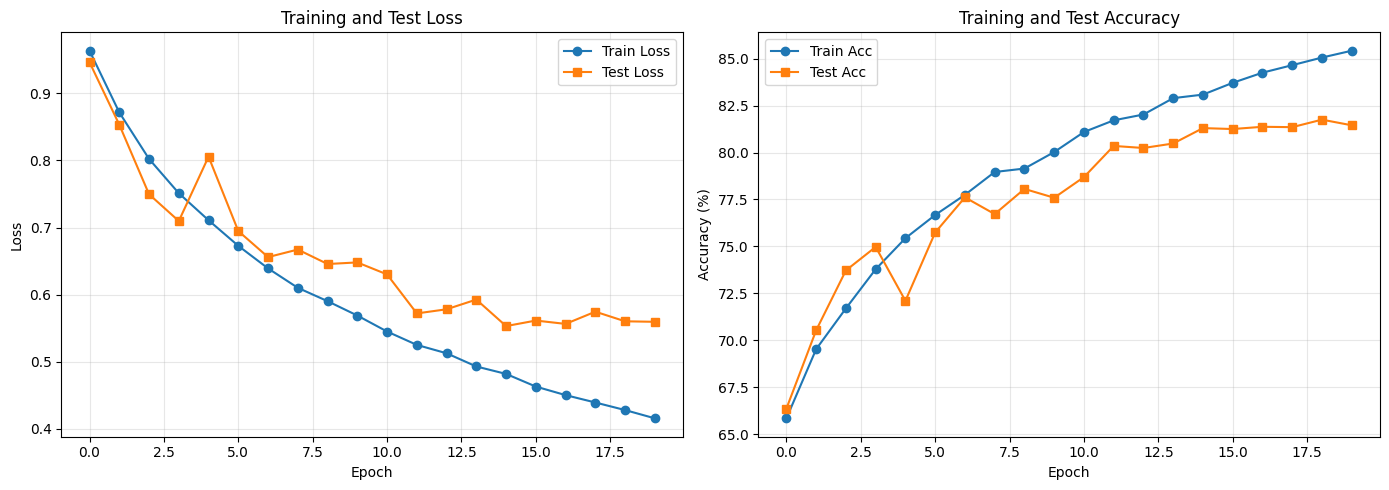

 Plot saved!


In [18]:
# ==================== PLOT ====================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(test_losses, label='Test Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Test Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accuracies, label='Train Acc', marker='o')
axes[1].plot(test_accuracies, label='Test Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Test Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./results/training_history.png', dpi=150)
plt.show()
print(" Plot saved!")


In [19]:
# ==================== SUMMARY ====================

print("\n" + "="*60)
print("BASELINE MODEL COMPLETE")
print("="*60)
print(f"Best Test Accuracy: {max(test_accuracies):.2f}%")
print(f"Model saved to: ./models/baseline_resnet18_best.pth")
print("="*60)
print("\n Ready for adversarial attacks!")



BASELINE MODEL COMPLETE
Best Test Accuracy: 81.75%
Model saved to: ./models/baseline_resnet18_best.pth

 Ready for adversarial attacks!
